In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install keras-unet

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# DATA_PATH = './data_new/2017_numpy'
DATA_PATH = '/content/drive/My Drive/Insight/2017_numpy'
FRAME_PATH = DATA_PATH+'/frames/'
MASK_PATH = DATA_PATH+'/masks/'

## Loading 2017 data

In [0]:
HEIGHT = 1400
WIDTH = 1400

# def load_data():
    
X = []
y = []

for file in sorted(os.listdir(FRAME_PATH)):   
    if file.startswith('R'):
        filename = file.split('.')[0]

        frame = np.load(os.path.join(FRAME_PATH, filename + '.npy'))
        mask = np.load(os.path.join(MASK_PATH, filename + '_labels.npy'))
        X.append(frame[:HEIGHT, :WIDTH, :])
        y.append(mask[:HEIGHT, :WIDTH])

X = np.array(X)
y = np.array(y)

# return X, y

In [0]:
from sklearn.preprocessing import StandardScaler

def standardize(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

## Cropping 512x512 image patches to feed into network

In [0]:
from PIL import Image
import numpy as np
from keras_unet.utils import get_patches

# x = np.array(Image.open("../docs/sat_image_1.jpg"))
# print("x shape: ", str(x.shape))

X_crops = []
y_crops = []

CROP_X = 512
CROP_Y = 512

for i, x in enumerate(X):
  x_cropped = get_patches(
      img_arr=x, # required - array of images to be cropped
      size=CROP_X, # default is 256
      stride=CROP_X) # default is 256
  
  y_cropped = get_patches(
    img_arr=y[i].reshape(HEIGHT,WIDTH,1), # required - array of images to be cropped
    size=CROP_X, 
    stride=CROP_X)
  
  X_crops.append(x_cropped)
  y_crops.append(y_cropped)

In [0]:
X_crops = np.array(X_crops)
y_crops = np.array(y_crops)

X_cropped = X_crops.reshape(X_crops.shape[0]*X_crops.shape[1], X_crops.shape[2], X_crops.shape[3],  X_crops.shape[4])
y_cropped = y_crops.reshape(y_crops.shape[0]*y_crops.shape[1], y_crops.shape[2], y_crops.shape[3], 1)

## Peparing data for training

In [0]:
from sklearn.model_selection import train_test_split

X_reshaped = X_cropped.reshape(X_cropped.shape[0] * CROP_X * CROP_Y,13)
X_std = standardize(X_reshaped)
X_ = X_std.reshape(X_cropped.shape[0], CROP_X, CROP_Y, 13)

X_train, X_test, y_train, y_test = train_test_split(X_, y_cropped, test_size=0.2, shuffle=False)

## Data augmentation generator - horizontal and vertical flip

In [29]:
from keras_unet.utils import get_augmented

train_gen = get_augmented(
    X_train, y_train, batch_size=2,
    data_gen_args = dict(
#         rotation_range=5.,
#         width_shift_range=0.05,
#         height_shift_range=0.05,
#         shear_range=40,
#         zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
#         fill_mode='constant'
    ))

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:940: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (96, 512, 512, 13) (13 channels).
  ' channels).')
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (96, 512, 512, 13) (13 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


## Building and compiling U-Net model

In [0]:
from keras_unet.models import custom_unet

input_shape = X_train[0].shape

model = custom_unet(
    input_shape,
    filters=32,
    use_batch_norm=True,
    dropout=0.3,
#     dropout=0.4,
    dropout_change_per_layer=0.0,
    num_layers=4
)

In [32]:
from keras.optimizers import Adam, SGD
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance

model.compile(
    optimizer=Adam(), 
#     optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou]
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training model

In [33]:
history = model.fit_generator(
    train_gen,
    steps_per_epoch=10,
    epochs=10,
    validation_data=(X_test, y_test)
#     callbacks=[callback_checkpoint]
)

Epoch 1/10
10/10 [==============================] - 21s 2s/step - loss: 0.4751 - iou: 0.4558 - val_loss: 0.4078 - val_iou: 0.4829
Epoch 2/10
10/10 [==============================] - 8s 751ms/step - loss: 0.2557 - iou: 0.6436 - val_loss: 0.2622 - val_iou: 0.5579
Epoch 3/10
10/10 [==============================] - 8s 751ms/step - loss: 0.2231 - iou: 0.7019 - val_loss: 1.2937 - val_iou: 0.3828
Epoch 4/10
10/10 [==============================] - 8s 752ms/step - loss: 0.2244 - iou: 0.6799 - val_loss: 0.4388 - val_iou: 0.5795
Epoch 5/10
10/10 [==============================] - 8s 750ms/step - loss: 0.3066 - iou: 0.5550 - val_loss: 1.6556 - val_iou: 0.3464
Epoch 6/10
10/10 [==============================] - 8s 751ms/step - loss: 0.2128 - iou: 0.6827 - val_loss: 0.1933 - val_iou: 0.5775
Epoch 7/10
10/10 [==============================] - 8s 751ms/step - loss: 0.2379 - iou: 0.6750 - val_loss: 0.3206 - val_iou: 0.4259
Epoch 8/10
10/10 [==============================] - 8s 751ms/step - loss: 0.21

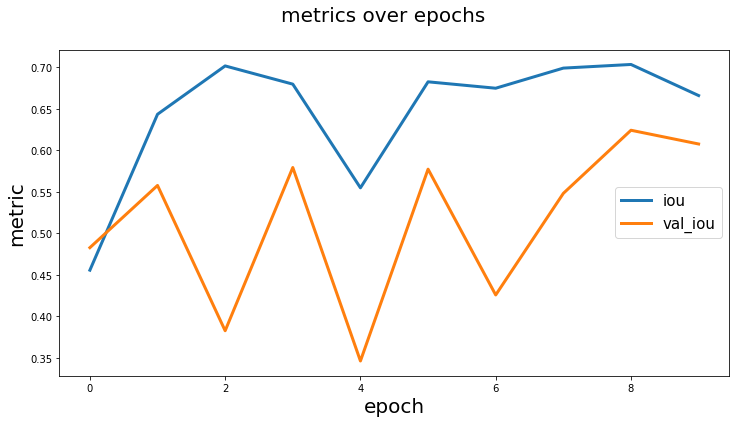

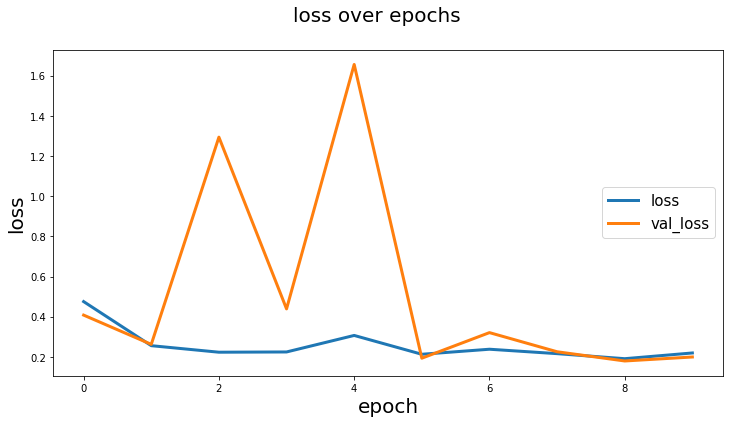

In [34]:
from keras_unet.utils import plot_segm_history

plot_segm_history(
    history, # required - keras training history object
    metrics=['iou', 'val_iou'], # optional - metrics names to plot
    losses=['loss', 'val_loss']) # optional - loss names to plot

## Predicting on 2017 test sample

In [0]:
y_pred = model.predict(X_test)

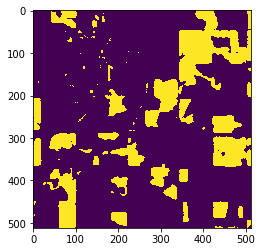

In [38]:
# Predicted 

y_pred_sample = y_pred[0].reshape(CROP_X, CROP_Y)
y_pred_binary = np.round_(y_pred_sample, 0)

plt.imshow(y_pred_binary)

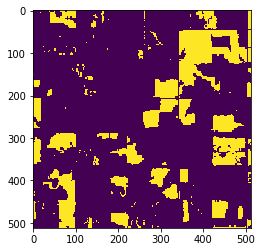

In [39]:
# Actual

plt.imshow(y_test[0].reshape(CROP_X, CROP_Y))

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print('Accuracy: %.2f' % accuracy_score(y_pred_binary.flatten(), y_test[0].flatten()))
print('Confusion Matrix: \n', confusion_matrix(y_pred_binary.flatten(), y_test[0].flatten()))
print('Classification report:\n', classification_report(y_pred_binary.flatten(), y_test[9].flatten()))

Accuracy: 0.94
Confusion Matrix: 
 [[202120   6255]
 [  8779  44990]]
Classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.97      0.96    208375
         1.0       0.88      0.84      0.86     53769

    accuracy                           0.94    262144
   macro avg       0.92      0.90      0.91    262144
weighted avg       0.94      0.94      0.94    262144

